In [ ]:
# # Data Dictionary
# # Variable Name	Description
# # LoanNr_ChkDgt	Identifier Primary key
# # Name	Borrower name
# # City	Borrower city
# # State	Borrower state
# # Zip	Borrower zip code
# # Bank	Bank name
# # BankState	Bank state
# # NAICS	North American industry classification system code
# # ApprovalDate	Date SBA commitment issued
# # ApprovalFY	Fiscal year of commitment
# # Term	Loan term in months
# # NoEmp	Number of business employees
# # NewExist	1 = Existing business, 2 = New business
# # CreateJob	Number of jobs created
# # RetainedJob	Number of jobs retained
# # FranchiseCode	Franchise code, (00000 or 00001) = No franchise
# # UrbanRural	1 = Urban, 2 = rural, 0 = undefined
# # RevLineCr	Revolving line of credit: Y = Yes, N = No
# # LowDoc	LowDoc Loan Program: Y = Yes, N = No
# # ChgOffDate	The date when a loan is declared to be in default
# # DisbursementDate	Disbursement date
# # DisbursementGross	Amount disbursed
# # BalanceGross	Gross amount outstanding
# # MIS_Status	Loan status charged off = CHGOFF, Paid in full =PIF
# # ChgOffPrinGr	Charged-off amount
# # GrAppv	Gross amount of loan approved by bank
# # SBA_Appv	SBA’s guaranteed amount of approved loan


# Description of the first two digits of NAICS.
# Sector	Description
# 11	Agriculture, forestry, fishing and hunting
# 21	Mining, quarrying, and oil and gas extraction
# 22	Utilities
# 23	Construction
# 31–33	Manufacturing
# 42	Wholesale trade
# 44–45	Retail trade
# 48–49	Transportation and warehousing
# 51	Information
# 52	Finance and insurance
# 53	Real estate and rental and leasing
# 54	Professional, scientific, and technical services
# 55	Management of companies and enterprises
# 56	Administrative and support and waste management and remediation services
# 61	Educational services
# 62	Health care and social assistance
# 71	Arts, entertainment, and recreation
# 72	Accommodation and food services
# 81	Other services (except public administration) 92 Public administration

In [2]:
import requests
import zipfile
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import os

# URL del dataset en Kaggle
url = "https://www.kaggle.com/api/v1/datasets/download/mirbektoktogaraev/should-this-loan-be-approved-or-denied"

# Descargamos el contenido
response = requests.get(url, allow_redirects=True)
if response.status_code == 200:
    print("Descarga completada ✅")
else:
    print("Error en la descarga:", response.status_code)

# Guardamos el zip en memoria
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Listamos los archivos dentro del zip
print("Archivos en el zip:", zip_file.namelist())

# Elegimos el CSV (ajustá el nombre según corresponda)
csv_filename = zip_file.namelist()[0]

# Leemos el CSV directamente desde el zip
df = pd.read_csv(zip_file.open(csv_filename))

pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas


# =========================
# Tomar alícuota aleatoria de 50 filas
# =========================
# if os.path.exists('aliquota_test.csv'):
#     print(f"✅ El archivo aliquota_test.csv existe en la carpeta.")
# else:
aliquota = df.sample(n=50, random_state=32)

# Guardar la alícuota en un CSV separado
aliquota.to_csv("aliquota_test.csv", index=False)

# Eliminar las filas seleccionadas del dataset original para entrenamiento
df_train = df.drop(aliquota.index).reset_index(drop=True)

# Revisar tamaños
print("Filas para entrenar:", len(df_train))
print("Filas reservadas para testeo:", len(aliquota))


Descarga completada ✅
Archivos en el zip: ['SBAnational.csv', 'Should This Loan be Approved or Denied A Large Dataset with Class Assignment Guidelines.pdf']


C:\Users\alejo\AppData\Local\Temp\ipykernel_20356\2309249944.py:32: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


Filas para entrenar: 899114
Filas reservadas para testeo: 50


In [3]:
def preprocess_cash_and_dates(df):
    """
    Limpia columnas de tipo cash y transforma columnas de fechas en columnas numéricas.
    
    Args:
        df (pd.DataFrame): DataFrame original
    
    Returns:
        pd.DataFrame: DataFrame con columnas cash convertidas a float y fechas desglosadas en componentes
    """
    
    # Columnas tipo cash a limpiar
    cash_encode = ['GrAppv','SBA_Appv','ChgOffPrinGr','DisbursementGross','BalanceGross']
    
    for col in cash_encode:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)
    
    # Columnas de fechas a transformar
    dates_encode = ['DisbursementDate', 'ApprovalDate']
    
    for col in dates_encode:
        if col in df.columns:
            # Convertir a datetime
            df[col] = pd.to_datetime(df[col], format='%d-%b-%y', errors='coerce')
            
            # Extraer componentes
            df[col + '_day'] = df[col].dt.day.fillna(0).astype('int32')
            df[col + '_month'] = df[col].dt.month.fillna(0).astype('int32')
            df[col + '_year'] = df[col].dt.year.fillna(0).astype('int32')
            df[col + '_weekday'] = df[col].dt.weekday.fillna(0).astype('int32')
            df[col + '_quarter'] = df[col].dt.quarter.fillna(0).astype('int32')
    
    # Eliminar las columnas de fecha originales
    df.drop(columns=[c for c in dates_encode if c in df.columns], inplace=True)
    
    return df


In [4]:
df=preprocess_cash_and_dates(df)
df.head(2)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,DisbursementDate_day,DisbursementDate_month,DisbursementDate_year,DisbursementDate_weekday,DisbursementDate_quarter,ApprovalDate_day,ApprovalDate_month,ApprovalDate_year,ApprovalDate_weekday,ApprovalDate_quarter
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997,84,4,2.0,0,0,1,0,N,Y,NaN,60000.0,0.0,P I F,0.0,60000.0,48000.0,28,2,1999,6,1,28,2,1997,4,1
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997,60,2,2.0,0,0,1,0,N,Y,NaN,40000.0,0.0,P I F,0.0,40000.0,32000.0,31,5,1997,5,2,28,2,1997,4,1


In [9]:
# df['NAICS'] = df['NAICS'].astype(str).apply(lambda x: x[:2])

# naics_dict = {
#     '11': 'Agriculture, forestry, fishing and hunting',
#     '21': 'Mining, quarrying, and oil and gas extraction',
#     '22': 'Utilities',
#     '23': 'Construction',
#     '31': 'Manufacturing',
#     '32': 'Manufacturing',
#     '33': 'Manufacturing',
#     '42': 'Wholesale trade',
#     '44': 'Retail trade',
#     '45': 'Retail trade',
#     '48': 'Transportation and warehousing',
#     '49': 'Transportation and warehousing',
#     '51': 'Information',
#     '52': 'Finance and insurance',
#     '53': 'Real estate and rental and leasing',
#     '54': 'Professional, scientific, and technical services',
#     '55': 'Management of companies and enterprises',
#     '56': 'Administrative and support and waste management and remediation services',
#     '61': 'Educational services',
#     '62': 'Health care and social assistance',
#     '71': 'Arts, entertainment, and recreation',
#     '72': 'Accommodation and food services',
#     '81': 'Other services (except public administration)',
#     '92': 'Public administration'
# }
# df['Industry'] = df['NAICS'].map(naics_dict)
# df[['NAICS','Industry']].head()



In [5]:
df['mean_GrAppv']=round(df['GrAppv'].mean(),2)

Data Analysis

Basic exploration data


In [5]:
df.sample(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,DisbursementDate_day,DisbursementDate_month,DisbursementDate_year,DisbursementDate_weekday,DisbursementDate_quarter,ApprovalDate_day,ApprovalDate_month,ApprovalDate_year,ApprovalDate_weekday,ApprovalDate_quarter
281328,2949565001,Luxury Residence Netwrok Inc.,NEW YORK,NY,10128,JPMORGAN CHASE BANK NATL ASSOC,IL,541613,2008,84,2,1.0,1,2,0,1,Y,N,NaN,25150.0,0.0,P I F,0.0,25000.0,12500.0,29,2,2008,4,1,11,2,2008,0,1
393905,3796524007,MARK CICCONE CONTRACTING,GREENVILLE,NY,12083,BANK OF AMERICA NATL ASSOC,RI,233210,2000,48,1,1.0,0,1,1,1,Y,N,NaN,18460.0,0.0,P I F,0.0,10000.0,5000.0,30,9,2000,5,3,16,6,2000,4,2
318204,3196274000,RAINBOW BOARD & CARE,VISTA,CA,92084,COMERICA BANK,TX,621610,1999,300,3,1.0,0,0,1,1,N,N,NaN,495000.0,0.0,P I F,0.0,495000.0,371250.0,31,12,1999,4,4,23,9,1999,3,3
497276,4810484010,TELEVIDEO SAN DIEGO,SAN DIEGO,CA,92111,WELLS FARGO BANK NATL ASSOC,CA,541512,2001,24,22,1.0,0,22,1,1,Y,N,NaN,150000.0,0.0,P I F,0.0,150000.0,75000.0,30,11,2001,4,4,13,8,2001,0,3
144017,2051914007,"VISTA MEDIA PRODUCTIONS, INC.",ALBUQUERQUE,NM,87110,WELLS FARGO BANK NATL ASSOC,NM,512110,1998,84,4,1.0,0,0,1,0,N,Y,NaN,95000.0,0.0,P I F,0.0,95000.0,76000.0,30,6,1998,1,2,12,5,1998,1,2


In [4]:
df.shape

(899164, 35)

In [7]:
round(df.describe(),2)

,LoanNr_ChkDgt,Zip,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,DisbursementDate_day,DisbursementDate_month,DisbursementDate_year,DisbursementDate_weekday,DisbursementDate_quarter,ApprovalDate_day,ApprovalDate_month,ApprovalDate_year,ApprovalDate_weekday,ApprovalDate_quarter,mean_GrAppv
count,8.991640e+05,899164.00,899164.00,899164.00,899028.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00
mean,4.772612e+09,53804.39,110.77,11.41,1.28,8.43,10.80,2753.73,0.76,201154.02,2.99,13503.30,192686.98,149488.79,27.64,6.34,1995.93,2.78,2.50,16.19,6.48,2000.91,2.14,2.49,192686.98
std,2.538175e+09,31184.16,78.86,74.11,0.45,236.69,237.12,12758.02,0.65,287640.85,1442.16,65152.29,283263.39,228414.56,7.44,3.44,102.73,1.95,1.12,8.76,3.36,5.91,1.39,1.09,0.00
min,1.000014e+09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00,100.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1969.00,0.00,1.00,192686.98
25%,2.589758e+09,27587.00,60.00,2.00,1.00,0.00,0.00,1.00,0.00,42000.00,0.00,0.00,35000.00,21250.00,30.00,4.00,1997.00,1.00,2.00,9.00,4.00,1996.00,1.00,2.00,192686.98
50%,4.361439e+09,55410.00,84.00,4.00,1.00,0.00,1.00,1.00,1.00,100000.00,0.00,0.00,90000.00,61250.00,31.00,6.00,2002.00,2.00,2.00,16.00,6.00,2002.00,2.00,2.00,192686.98
75%,6.904627e+09,83704.00,120.00,10.00,2.00,1.00,4.00,1.00,1.00,238000.00,0.00,0.00,225000.00,175000.00,31.00,9.00,2006.00,4.00,3.00,24.00,9.00,2006.00,3.00,3.00,192686.98
max,9.996003e+09,99999.00,569.00,9999.00,2.00,8800.00,9500.00,99999.00,2.00,11446325.00,996262.00,3512596.00,5472000.00,5472000.00,31.00,12.00,2068.00,6.00,4.00,31.00,12.00,2068.00,6.00,4.00,192686.98


In [8]:
df.dtypes

LoanNr_ChkDgt                 int64
Name                         object
City                         object
State                        object
Zip                           int64
Bank                         object
BankState                    object
NAICS                        object
ApprovalFY                   object
Term                          int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
ChgOffDate                   object
DisbursementGross           float64
BalanceGross                float64
MIS_Status                   object
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
Industry                     object
DisbursementDate_day          int32
DisbursementDate_month      

In [5]:
dfnull = df.isnull().sum().reset_index()
dfnull.columns = ['column', 'nulls']
dfnull=dfnull.query(" nulls > 0")
dfnull['mean']=dfnull['nulls'].mean()



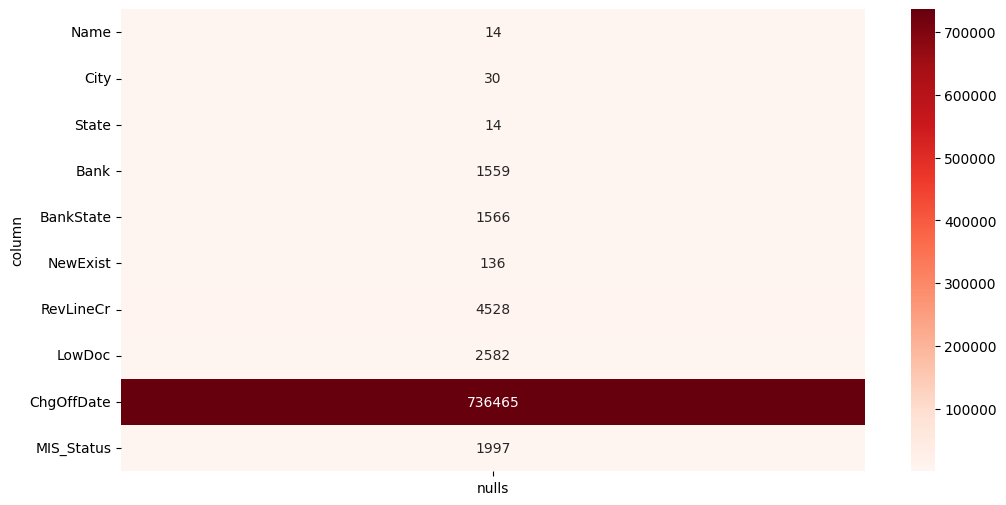

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(dfnull[['nulls']].set_index(dfnull['column']), annot=True, cmap="Reds",fmt="d")
plt.show()


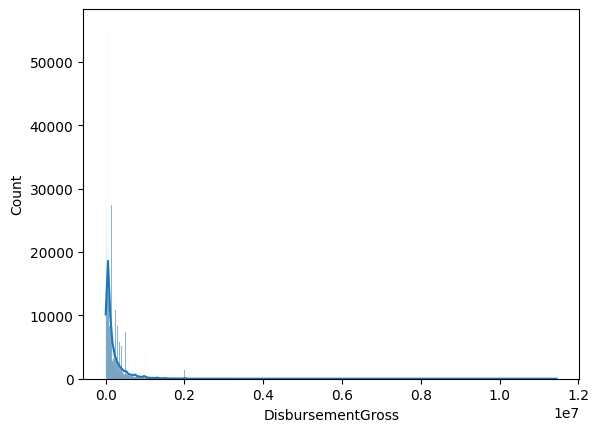

In [19]:
sns.histplot(df['DisbursementGross'], kde=True)
plt.show()

By States

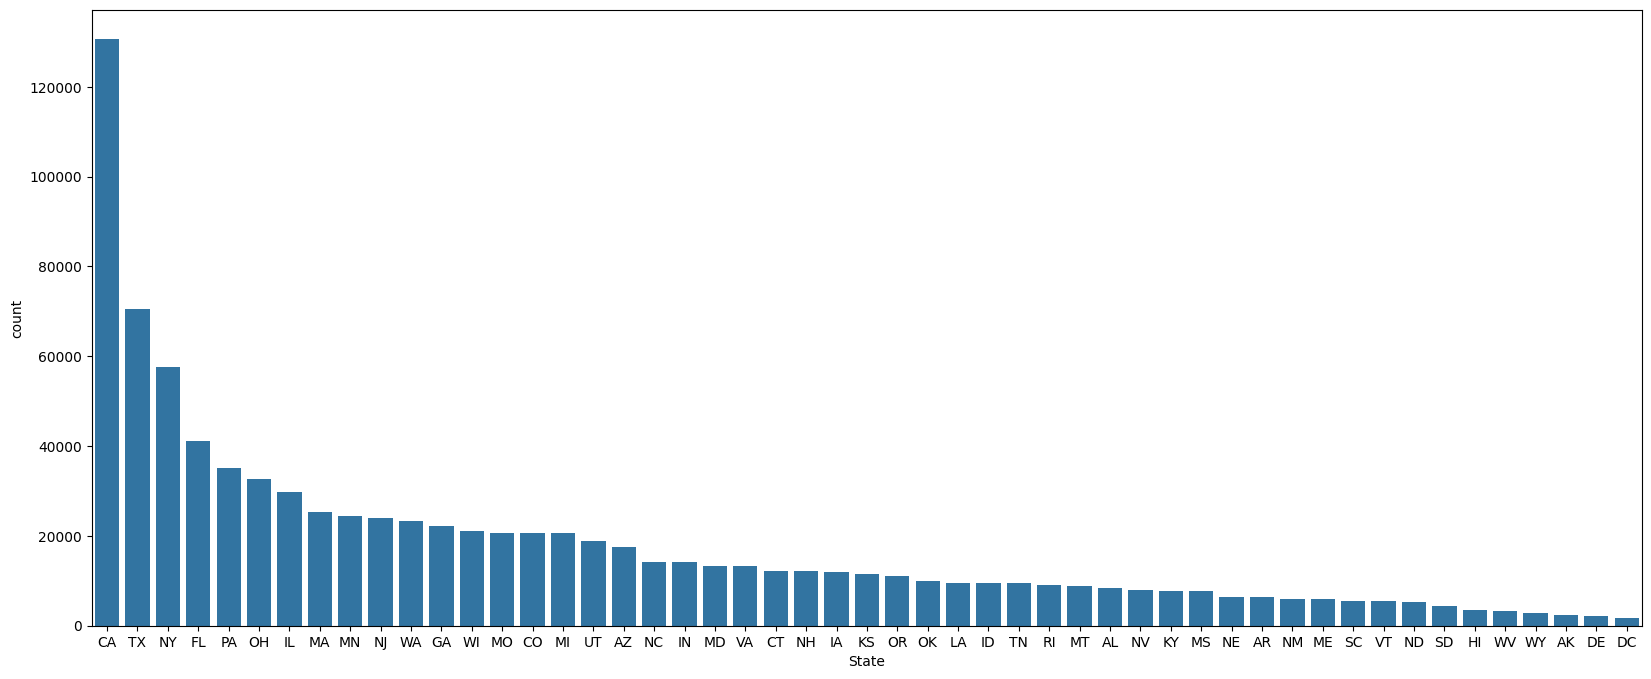

In [14]:
order = df['State'].value_counts().index
plt.figure(figsize=(20, 8))
sns.countplot(x='State', data=df, order=order)
plt.show()


In [21]:


df_grouped = df.groupby("State")[['ChgOffPrinGr']].mean().reset_index()

# Ahora sí podés graficar con choropleth
fig = px.choropleth(
    df_grouped,
    locations="State",        # columna con nombres de estados
    locationmode="USA-states",# para estados de USA
    color='ChgOffPrinGr',    # la primera columna numérica que quieras mapear
    scope="usa",
    color_continuous_scale="Turbo"
)

fig.update_layout(
    title_text="In which state people are less likely to pay off a loan?",
    title_x=0.5,
    coloraxis_colorbar=dict(
        title="Debt in K"
    )
)
fig.show()


In [22]:
df_grouped.head(5)

,State,ChgOffPrinGr
0,AK,14957.746778
1,AL,13477.031930
2,AR,14640.620722
3,AZ,21085.519766
4,CA,13855.606604


In [23]:


df_jobcreator = df.groupby("State")[['CreateJob']].mean().reset_index()

# Ahora sí podés graficar con choropleth
fig = px.choropleth(
    df_jobcreator,
    locations="State",        # columna con nombres de estados
    locationmode="USA-states",# para estados de USA
    color='CreateJob',    # la primera columna numérica que quieras mapear
    scope="usa",
    color_continuous_scale="Turbo"
)

fig.update_layout(
    title_text="In which state are more Jobs being created by Loans?",
    title_x=0.5,
    coloraxis_colorbar=dict(
        title="New Created Jobs"
    )
)
fig.show()


In [3]:
df.head(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,60000.0,0.0,P I F,0.0,60000.0,48000.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,40000.0,0.0,P I F,0.0,40000.0,32000.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,287000.0,0.0,P I F,0.0,287000.0,215250.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,35000.0,0.0,P I F,0.0,35000.0,28000.0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,229000.0,0.0,P I F,0.0,229000.0,229000.0


In [ ]:
df_BalanceGross=df.query("ChgOffPrinGr > 0")
df_BalanceGross

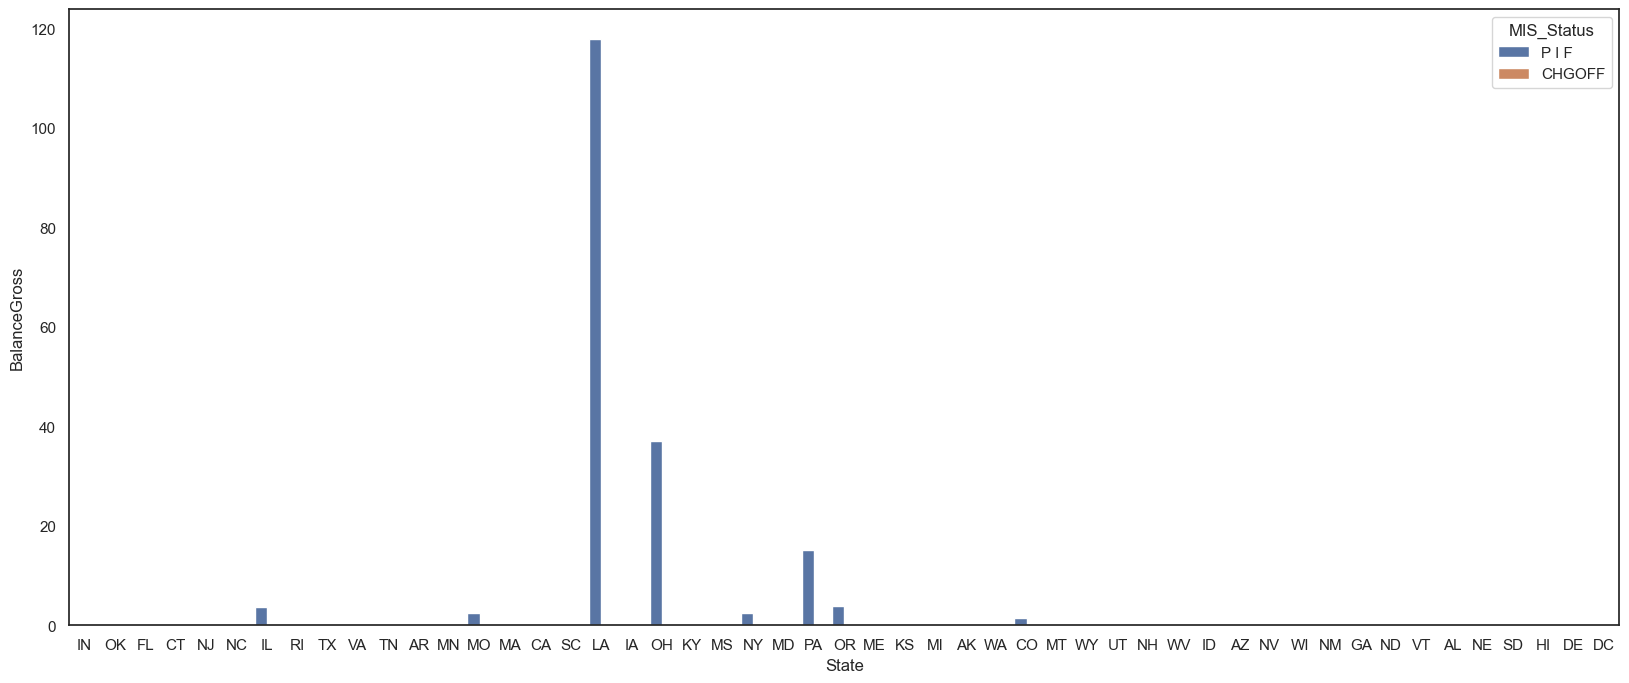

In [19]:

sns.set_theme(style="white")


plt.figure(figsize=(20, 8))

sns.barplot(x="State", y="BalanceGross", hue="MIS_Status", data=df, errorbar=None)

plt.show()

By Season, some of the chart have been splitted as a result of the amount of data of the data set

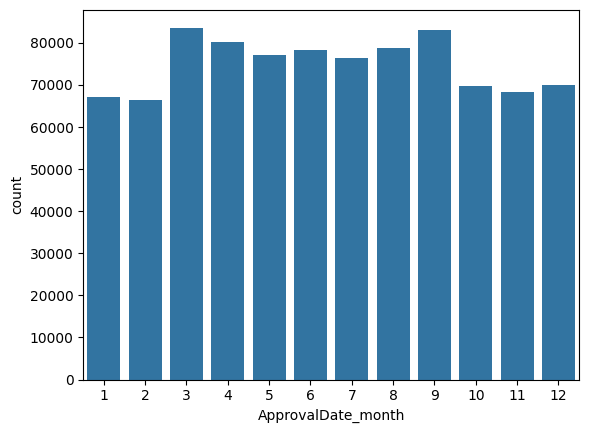

In [9]:
sns.countplot(x=df['ApprovalDate_month'])
plt.show()


In [54]:
df_year = df.groupby("ApprovalDate_year")[['GrAppv']].mean().reset_index()
df_year.head(10)

,ApprovalDate_year,GrAppv
0,1969,74925.000000
1,1970,102797.894737
2,1971,136433.333333
3,1972,138807.608696
4,1973,175647.826087
5,1974,122834.687500
6,1975,136951.020408
7,1976,150461.363636
8,1977,191335.460993
9,1978,190638.148148


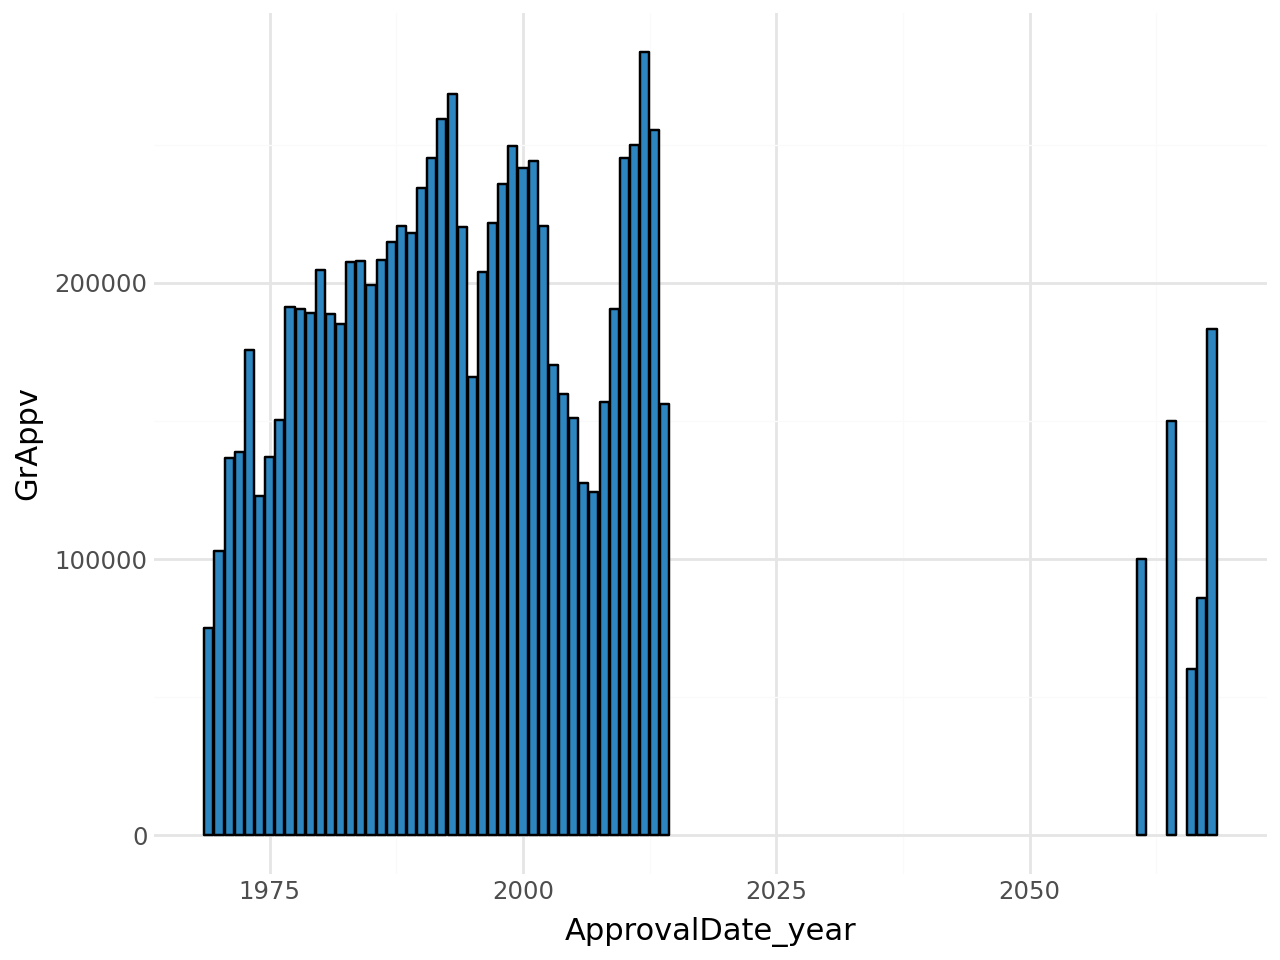

In [58]:

(
    ggplot(df_year, aes(x="ApprovalDate_year", y="GrAppv")) 
    + geom_bar(stat="identity", fill="#2E86C1", color="black") 
    + theme_minimal()
)

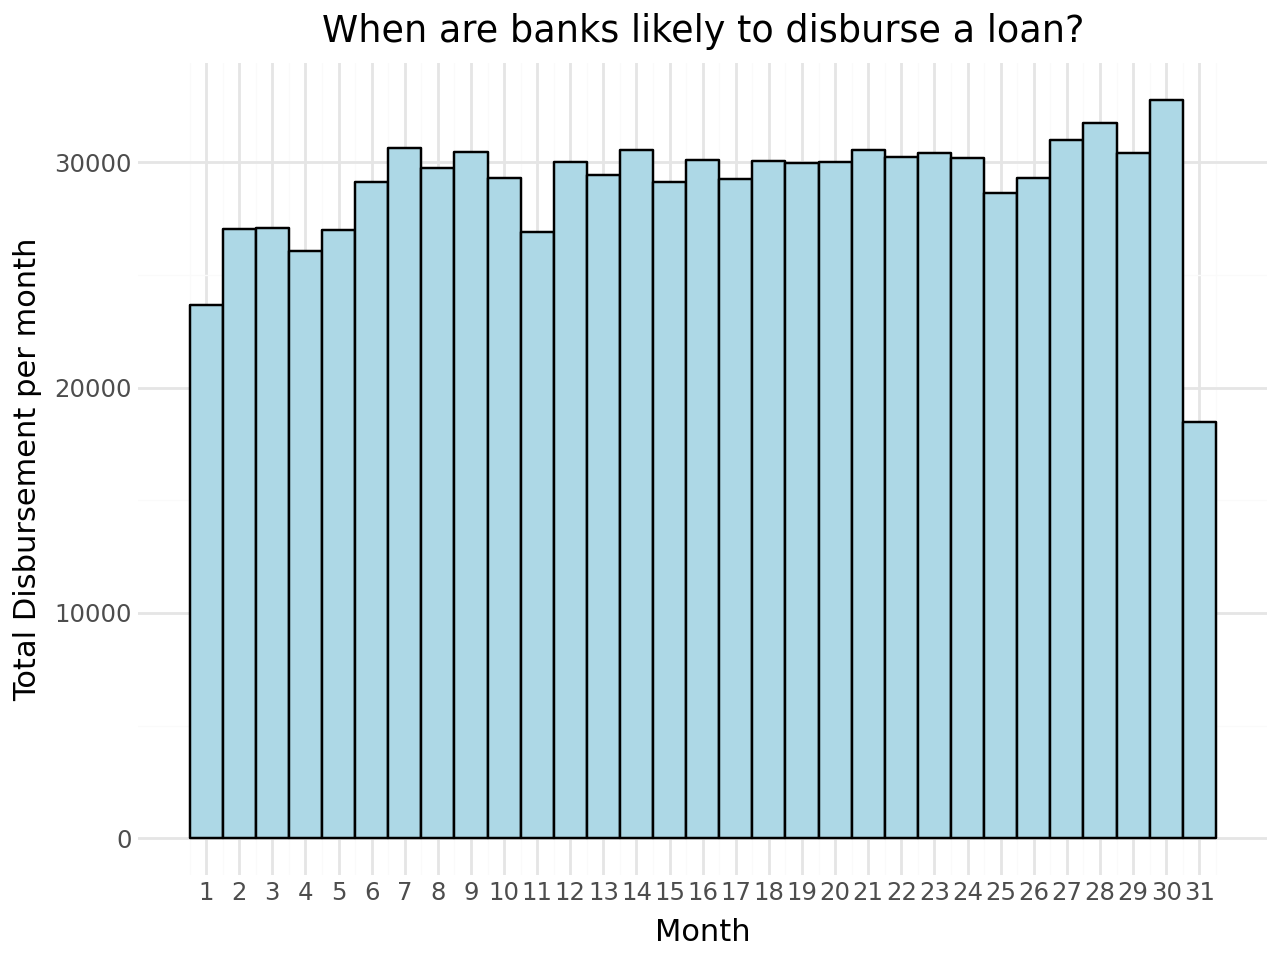

In [ ]:
(
ggplot(df, aes(x='ApprovalDate_day')) +
    geom_histogram(bins=31, fill='lightblue', color='black') +
    labs(
    title="When are banks likely to disburse a loan?",
    # subtitle='Banks with 50 or more loans anually',
    x="day",
    y="Total Disbursement per day")
    + theme_minimal()
    + scale_x_continuous(breaks=range(1, 32))
)

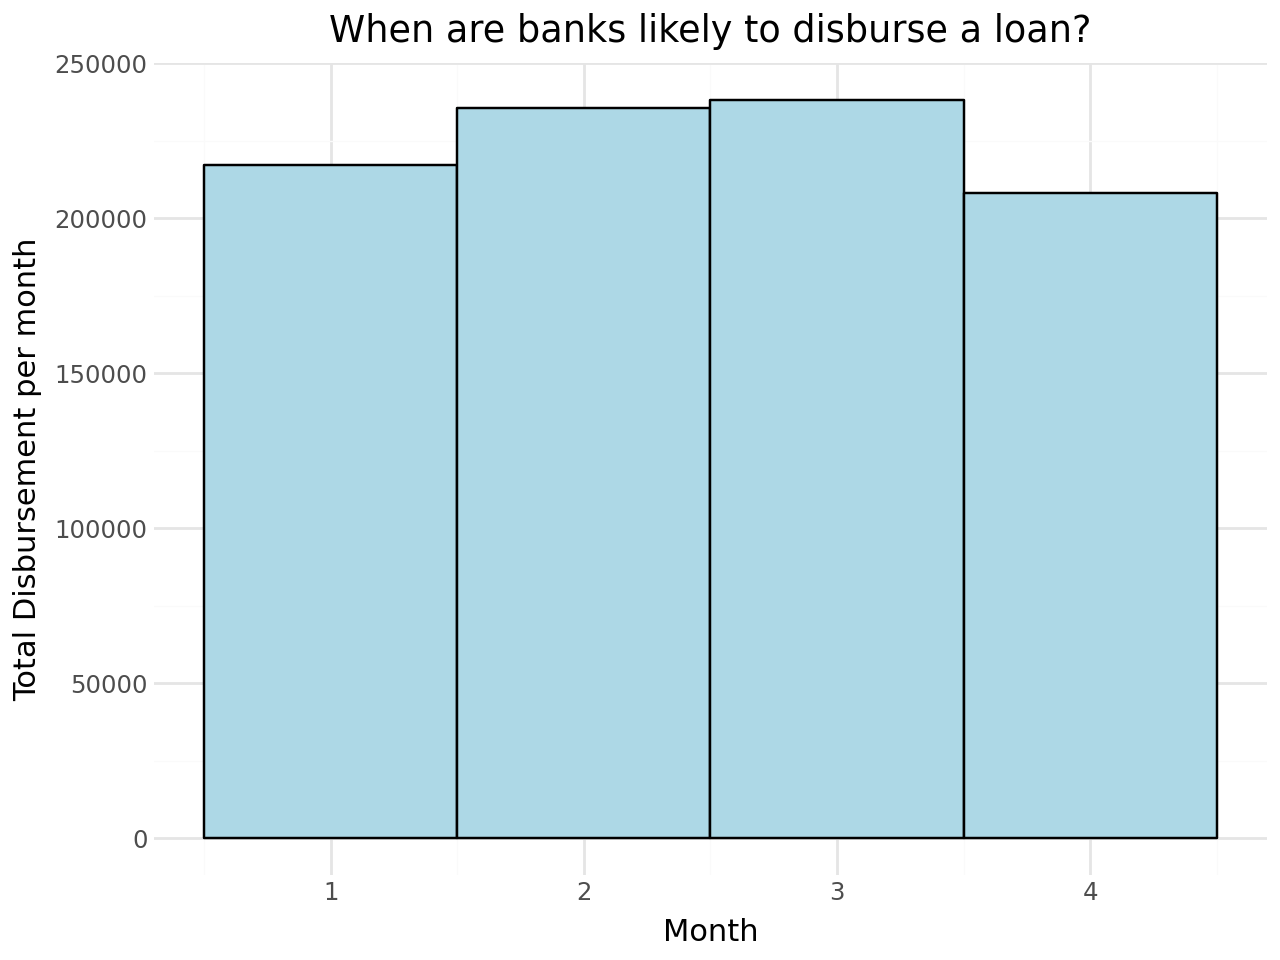

In [ ]:
(
ggplot(df, aes(x='ApprovalDate_quarter')) +
    geom_histogram(bins=4, fill='lightblue', color='black') +
    labs(
    title="When are banks likely to disburse a loan?",
    # subtitle='Banks with 50 or more loans anually',
    x="quarter",
    y="Total Disbursement per quarter")
    + theme_minimal()
    + scale_x_continuous(breaks=range(1, 5))
)

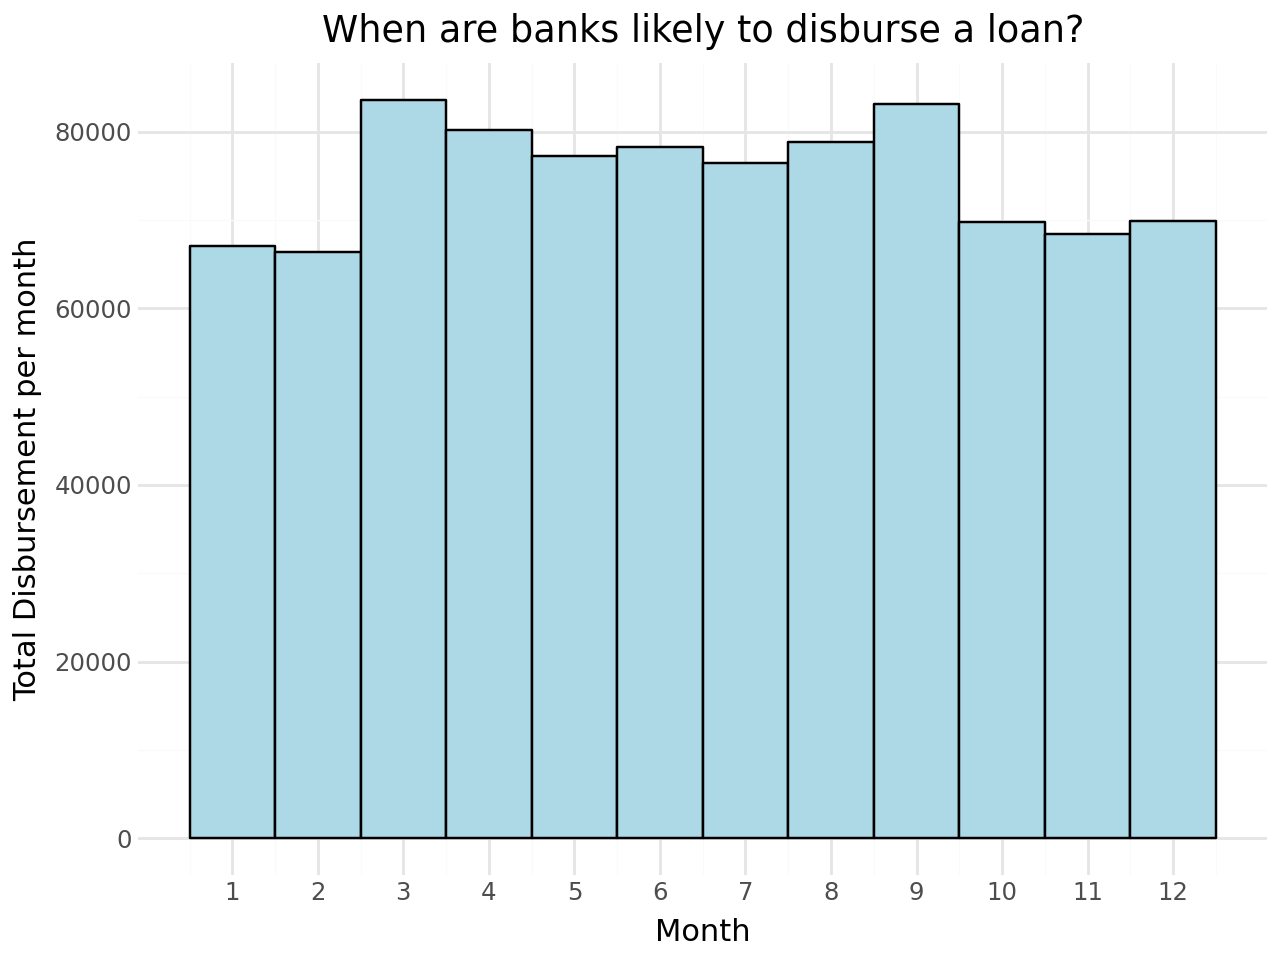

In [46]:
(
ggplot(df, aes(x='ApprovalDate_month')) +
    geom_histogram(bins=12, fill='lightblue', color='black') +
    labs(
    title="When are banks likely to disburse a loan?",
    # subtitle='Banks with 50 or more loans anually',
    x="Month",
    y="Total Disbursement per month")
    + theme_minimal()
    + scale_x_continuous(breaks=range(1, 13))
)

In [8]:
# Contar cuántas veces aparece cada banco
M50banks = df['Bank'].value_counts()

# Filtrar solo los que tienen al menos 50 ocurrencias
M50 = M50banks[M50banks >= 50].index

# Filtrar el DataFrame original para quedarse solo con esos bancos
df_M50banks = df[df['Bank'].isin(M50)]
df_M50banks.head(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry,DisbursementDate_day,DisbursementDate_month,DisbursementDate_year,DisbursementDate_weekday,DisbursementDate_quarter,ApprovalDate_day,ApprovalDate_month,ApprovalDate_year,ApprovalDate_weekday,ApprovalDate_quarter
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997,84,4,2.0,0,0,1,0,N,Y,NaN,60000.0,0.0,P I F,0.0,60000.0,48000.0,Retail trade,28,2,1999,6,1,28,2,1997,4,1
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,72,1997,60,2,2.0,0,0,1,0,N,Y,NaN,40000.0,0.0,P I F,0.0,40000.0,32000.0,Accommodation and food services,31,5,1997,5,2,28,2,1997,4,1
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997,60,2,1.0,0,0,1,0,N,Y,NaN,35000.0,0.0,P I F,0.0,35000.0,28000.0,NaN,30,6,1997,0,2,28,2,1997,4,1
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997,240,14,1.0,7,7,1,0,N,N,NaN,229000.0,0.0,P I F,0.0,229000.0,229000.0,NaN,14,5,1997,2,2,28,2,1997,4,1
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,33,1997,120,19,1.0,0,0,1,0,N,N,NaN,517000.0,0.0,P I F,0.0,517000.0,387750.0,Manufacturing,30,6,1997,0,2,28,2,1997,4,1


In [24]:
df_M50banks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 850146 entries, 0 to 899163
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   LoanNr_ChkDgt             850146 non-null  int64  
 1   Name                      850132 non-null  object 
 2   City                      850120 non-null  object 
 3   State                     850135 non-null  object 
 4   Zip                       850146 non-null  int64  
 5   Bank                      850146 non-null  object 
 6   BankState                 850146 non-null  object 
 7   NAICS                     850146 non-null  object 
 8   ApprovalFY                850146 non-null  object 
 9   Term                      850146 non-null  int64  
 10  NoEmp                     850146 non-null  int64  
 11  NewExist                  850020 non-null  float64
 12  CreateJob                 850146 non-null  int64  
 13  RetainedJob               850146 non-null  int64 

In [9]:
df_sum = df_M50banks.groupby("DisbursementDate_month", as_index=False)["DisbursementGross"].sum()

In [10]:
df_sum['DisbursementGross'].sum()

np.float64(170674647715.0)

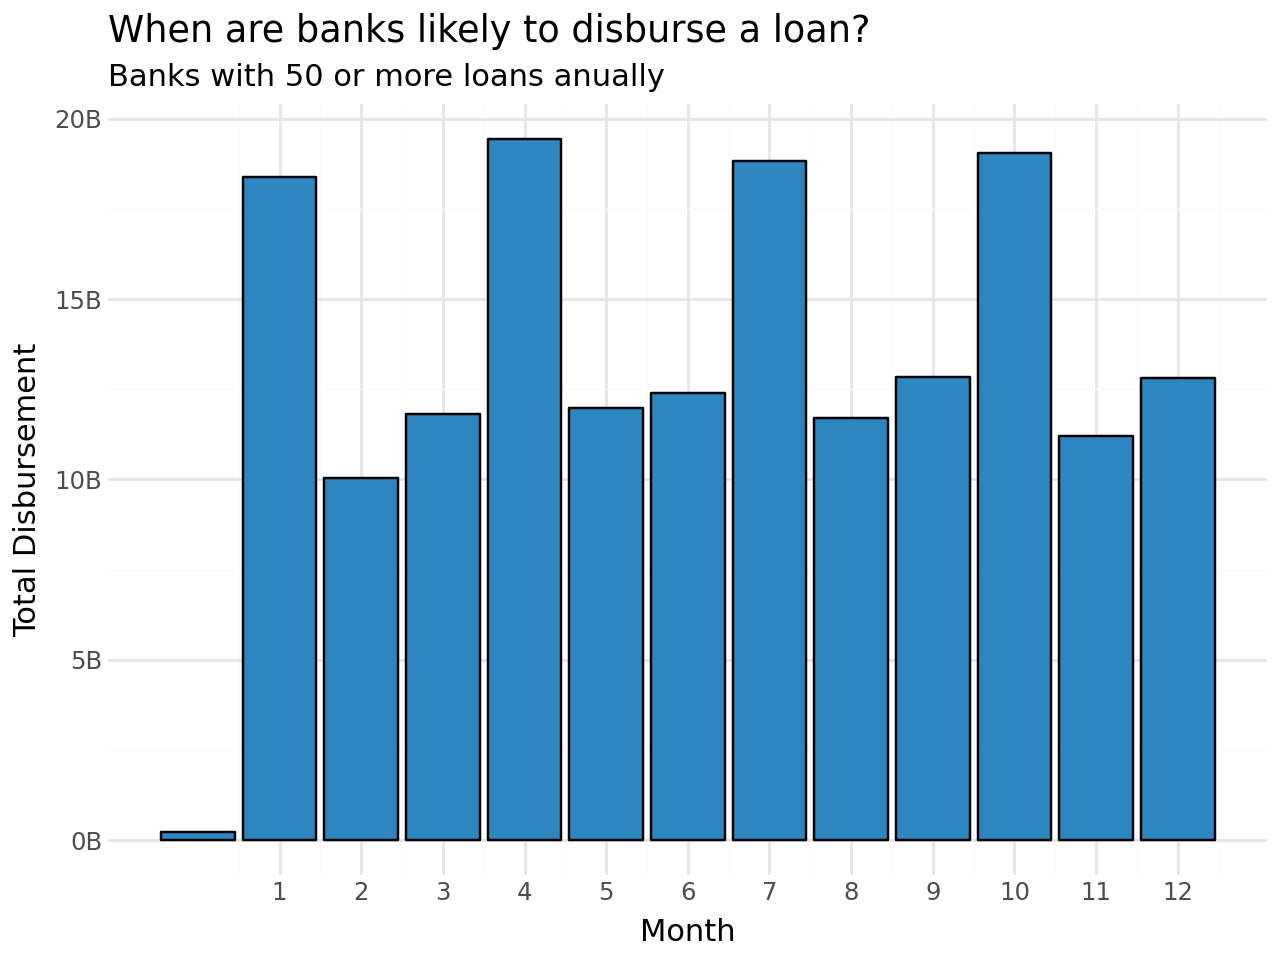

In [11]:

(
    ggplot(df_sum, aes(x="DisbursementDate_month", y="DisbursementGross")) 
    + geom_bar(stat="identity", fill="#2E86C1", color="black") 
    + labs(
        title="When are banks likely to disburse a loan?",
        subtitle='Banks with 50 or more loans anually',
        x="Month",
        y="Total Disbursement")
    + theme_minimal()
    + scale_x_continuous(breaks=range(1, 13))
    + scale_y_continuous(labels=lambda l: [f"{int(v/1e9)}B" for v in l])

)

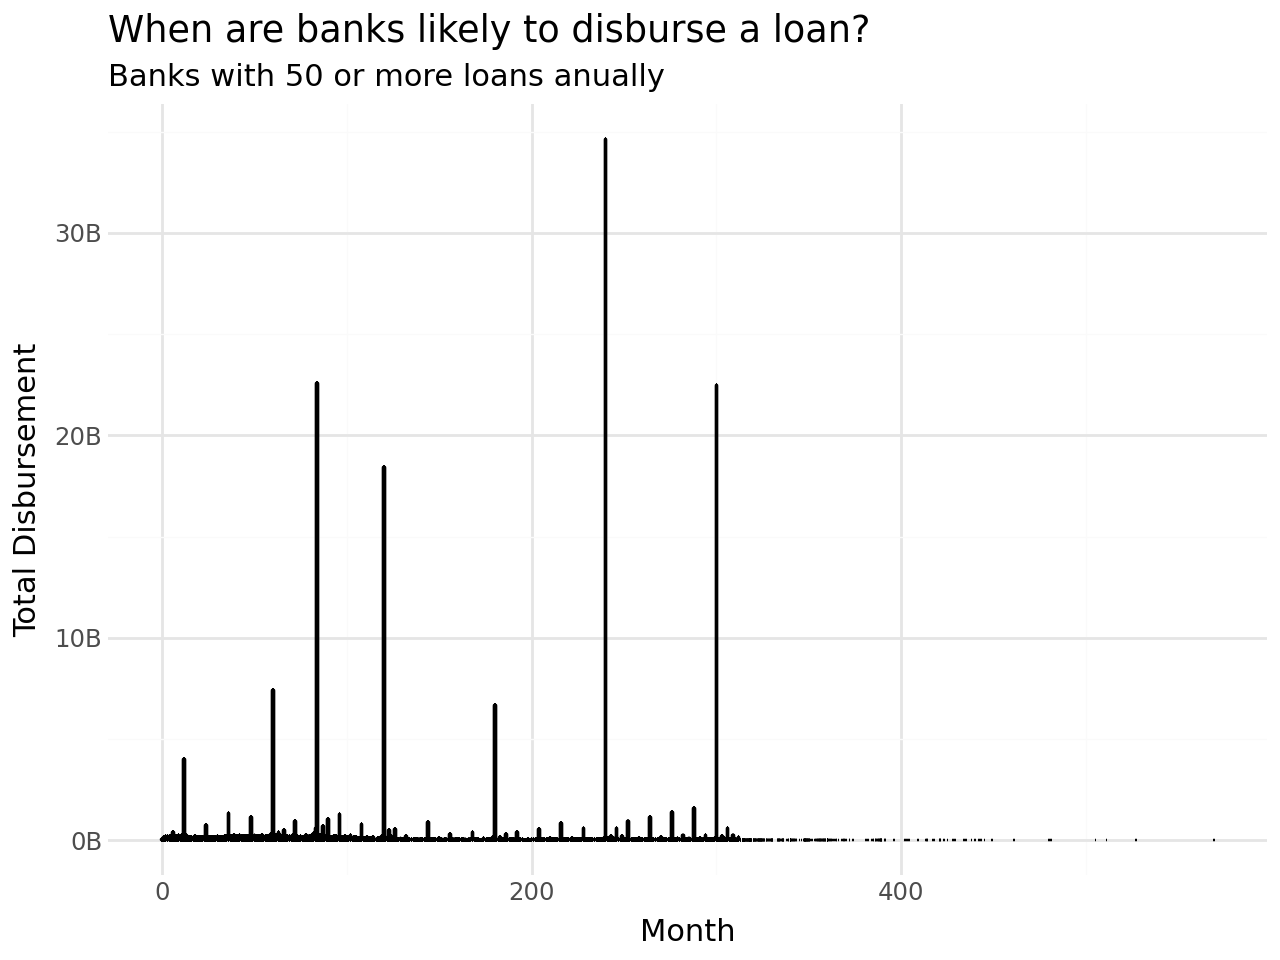

In [12]:
(
    ggplot(df_M50banks, aes(x="Term", y="DisbursementGross")) 
    + geom_bar(stat="identity", fill="#2E86C1", color="black") 
    + labs(
        title="When are banks likely to disburse a loan?",
        subtitle='Banks with 50 or more loans anually',
        x="Month",
        y="Total Disbursement")
    + theme_minimal()
    # + scale_x_continuous(breaks=range(1, 13))
    + scale_y_continuous(labels=lambda l: [f"{int(v/1e9)}B" for v in l])

)

In [48]:
# Contar cuántas veces aparece cada banco
L50banks = df['Bank'].value_counts()

# Filtrar solo los que tienen al menos 50 ocurrencias
L50 = L50banks[L50banks < 50].index

# Filtrar el DataFrame original para quedarse solo con esos bancos
df_L50banks = df[df['Bank'].isin(L50)]
df_L50banks.head(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry,DisbursementDate_day,DisbursementDate_month,DisbursementDate_year,DisbursementDate_weekday,DisbursementDate_quarter,ApprovalDate_day,ApprovalDate_month,ApprovalDate_year,ApprovalDate_weekday,ApprovalDate_quarter
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,62,1997,180,7,1.0,0,0,1,0,N,N,NaN,287000.0,0.0,P I F,0.0,287000.0,215250.0,Health care and social assistance,31,12,1997,2,4,28,2,1997,4,1
24,1000446006,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,72,2006,126,7,1.0,0,0,1,1,N,N,NaN,137300.0,0.0,P I F,0.0,137300.0,116705.0,Accommodation and food services,30,4,2006,6,2,7,2,2006,1,1
31,1000524003,AUDELIA FAMILY DENTAL GROUP,DALLAS,TX,75243,THE FROST NATIONAL BANK,TX,62,1997,102,12,1.0,0,0,1,0,N,N,NaN,600000.0,0.0,P I F,0.0,600000.0,450000.0,Health care and social assistance,31,7,1997,3,3,28,2,1997,4,1
33,1000534006,PPP COMMUNICATIONS,WASHINGTON,IA,52353,WASHINGTON STATE BANK,IA,45,1997,84,2,2.0,0,0,1,0,N,N,NaN,30000.0,0.0,P I F,0.0,30000.0,22500.0,Retail trade,31,10,1997,4,4,28,2,1997,4,1
143,1001236004,"LIQUID SUN COMPANY, LLC",BRANDON,FL,33511,THE BANK OF TAMPA,FL,71,2006,84,5,2.0,0,0,1,1,N,N,NaN,275000.0,0.0,P I F,0.0,275000.0,206250.0,"Arts, entertainment, and recreation",30,4,2006,6,2,7,2,2006,1,1


In [50]:
df_Lsum = df_L50banks.groupby("DisbursementDate_month", as_index=False)["DisbursementGross"].sum()

In [55]:
df_Lsum['DisbursementGross'].max()

np.float64(1182825953.0)

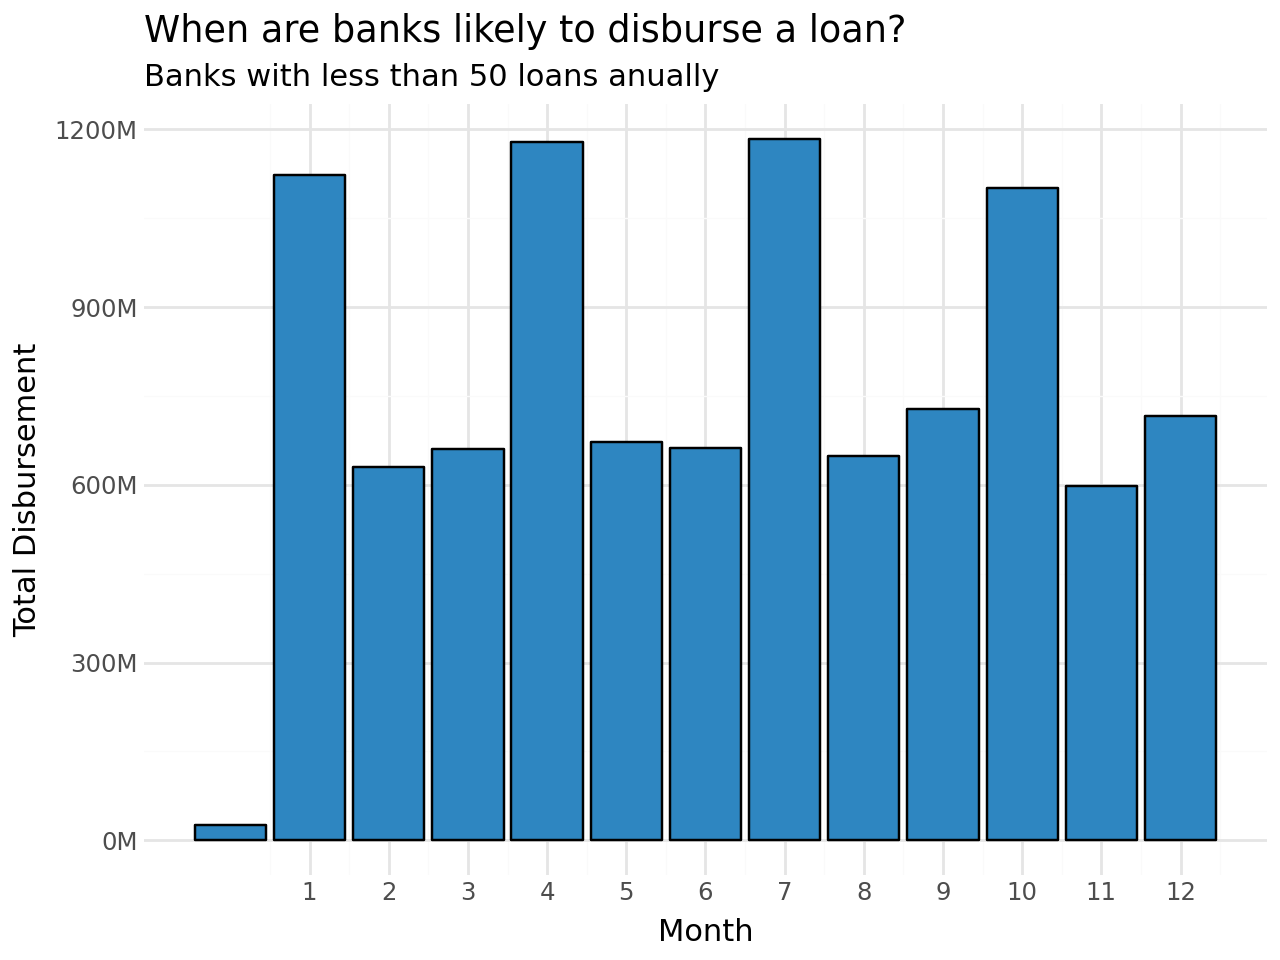

In [57]:

(
    ggplot(df_Lsum, aes(x="DisbursementDate_month", y="DisbursementGross")) 
    + geom_bar(stat="identity", fill="#2E86C1", color="black") 
    + labs(
        title="When are banks likely to disburse a loan?",
        subtitle='Banks with less than 50 loans anually',
        x="Month",
        y="Total Disbursement")
    + theme_minimal()
    + scale_x_continuous(breaks=range(1, 13))
    + scale_y_continuous(labels=lambda l: [f"{int(v/1e6)}M" for v in l])

)

By Amount

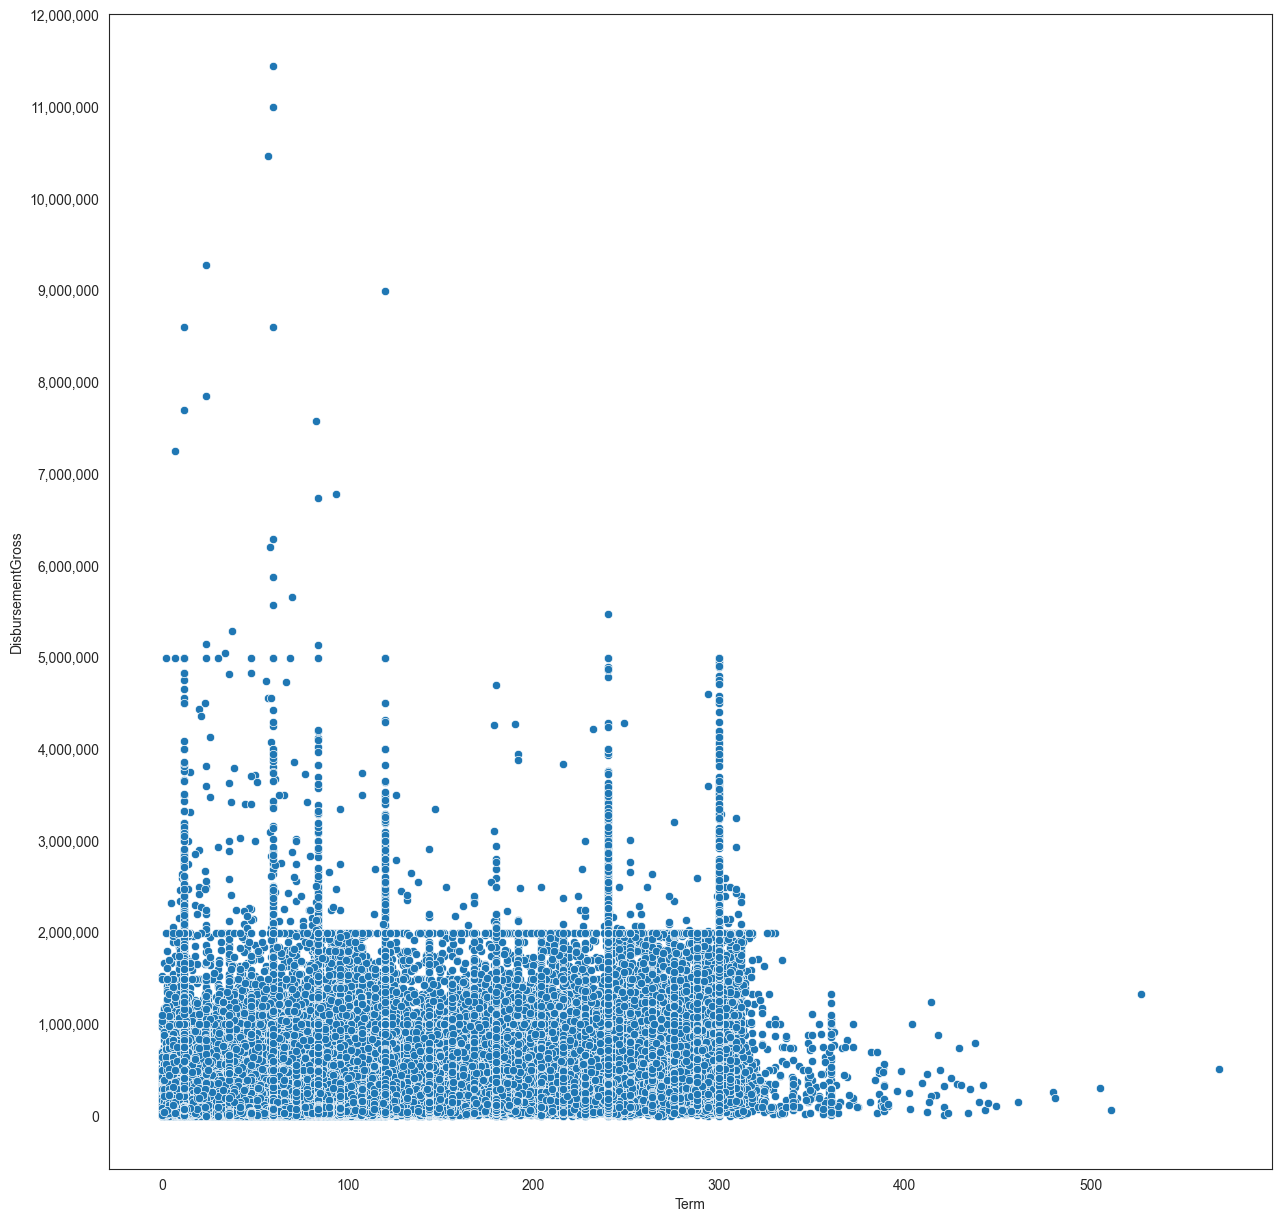

In [37]:
import matplotlib.ticker as ticker
plt.figure(figsize=(15, 15))

sns.scatterplot(x=df['Term'], y=df['DisbursementGross'])

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1_000_000))

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(100))

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

def encode_for_tree_models(df):
    """
    Prepara los datos para RandomForest o XGBoost:
    - Imputa valores nulos (numéricos con la media, categóricos con 'missing')
    - Aplica Label Encoding en columnas categóricas
    """
    df_encoded = df.copy()

    # 1️⃣ Manejo de valores nulos
    # Numéricos → reemplazo con media
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
    imputer_num = SimpleImputer(strategy='mean')
    df_encoded[num_cols] = imputer_num.fit_transform(df_encoded[num_cols])

    # Categóricos → reemplazo con "missing"
    cat_cols = df_encoded.select_dtypes(exclude=['int64', 'float64']).columns
    df_encoded[cat_cols] = df_encoded[cat_cols].fillna('missing').astype(str)

    # 2️⃣ Label Encoding para categóricas
    le = LabelEncoder()
    for col in cat_cols:
        df_encoded[col] = le.fit_transform(df_encoded[col])

    return df_encoded


In [6]:
df_tokenized = encode_for_tree_models(df)


In [7]:
df_tokenized.isnull().sum()

LoanNr_ChkDgt               0
Name                        0
City                        0
State                       0
Zip                         0
Bank                        0
BankState                   0
NAICS                       0
ApprovalFY                  0
Term                        0
NoEmp                       0
NewExist                    0
CreateJob                   0
RetainedJob                 0
FranchiseCode               0
UrbanRural                  0
RevLineCr                   0
LowDoc                      0
ChgOffDate                  0
DisbursementGross           0
BalanceGross                0
MIS_Status                  0
ChgOffPrinGr                0
GrAppv                      0
SBA_Appv                    0
DisbursementDate_day        0
DisbursementDate_month      0
DisbursementDate_year       0
DisbursementDate_weekday    0
DisbursementDate_quarter    0
ApprovalDate_day            0
ApprovalDate_month          0
ApprovalDate_year           0
ApprovalDa

In [8]:
df_tokenized.head(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,DisbursementDate_day,DisbursementDate_month,DisbursementDate_year,DisbursementDate_weekday,DisbursementDate_quarter,ApprovalDate_day,ApprovalDate_month,ApprovalDate_year,ApprovalDate_weekday,ApprovalDate_quarter
0,1.000014e+09,12791,8558,15,47711.0,2143,38,451120.0,34,84.0,4.0,2.0,0.0,0.0,1.0,0.0,12,7,6448,60000.0,0.0,1,0.0,60000.0,48000.0,21,5,31,6,1,20,4,28,4,0
1,1.000024e+09,405593,19588,15,46526.0,132,18,722410.0,34,60.0,2.0,2.0,0.0,0.0,1.0,0.0,12,7,6448,40000.0,0.0,1,0.0,40000.0,32000.0,25,8,29,5,2,20,4,28,4,0
2,1.000034e+09,759976,2206,15,47401.0,2859,18,621210.0,34,180.0,7.0,1.0,0.0,0.0,1.0,0.0,12,4,6448,287000.0,0.0,1,0.0,287000.0,215250.0,25,4,29,2,4,20,4,28,4,0
3,1.000044e+09,83888,2720,36,74012.0,25,39,0.0,34,60.0,2.0,1.0,0.0,0.0,1.0,0.0,12,7,6448,35000.0,0.0,1,0.0,35000.0,28000.0,24,9,29,0,2,20,4,28,4,0
4,1.000054e+09,38543,21134,9,32801.0,2683,11,0.0,34,240.0,14.0,1.0,7.0,7.0,1.0,0.0,12,4,6448,229000.0,0.0,1,0.0,229000.0,229000.0,6,8,29,2,2,20,4,28,4,0


In [8]:
correlation_matrix = df_tokenized.corr(numeric_only=True)

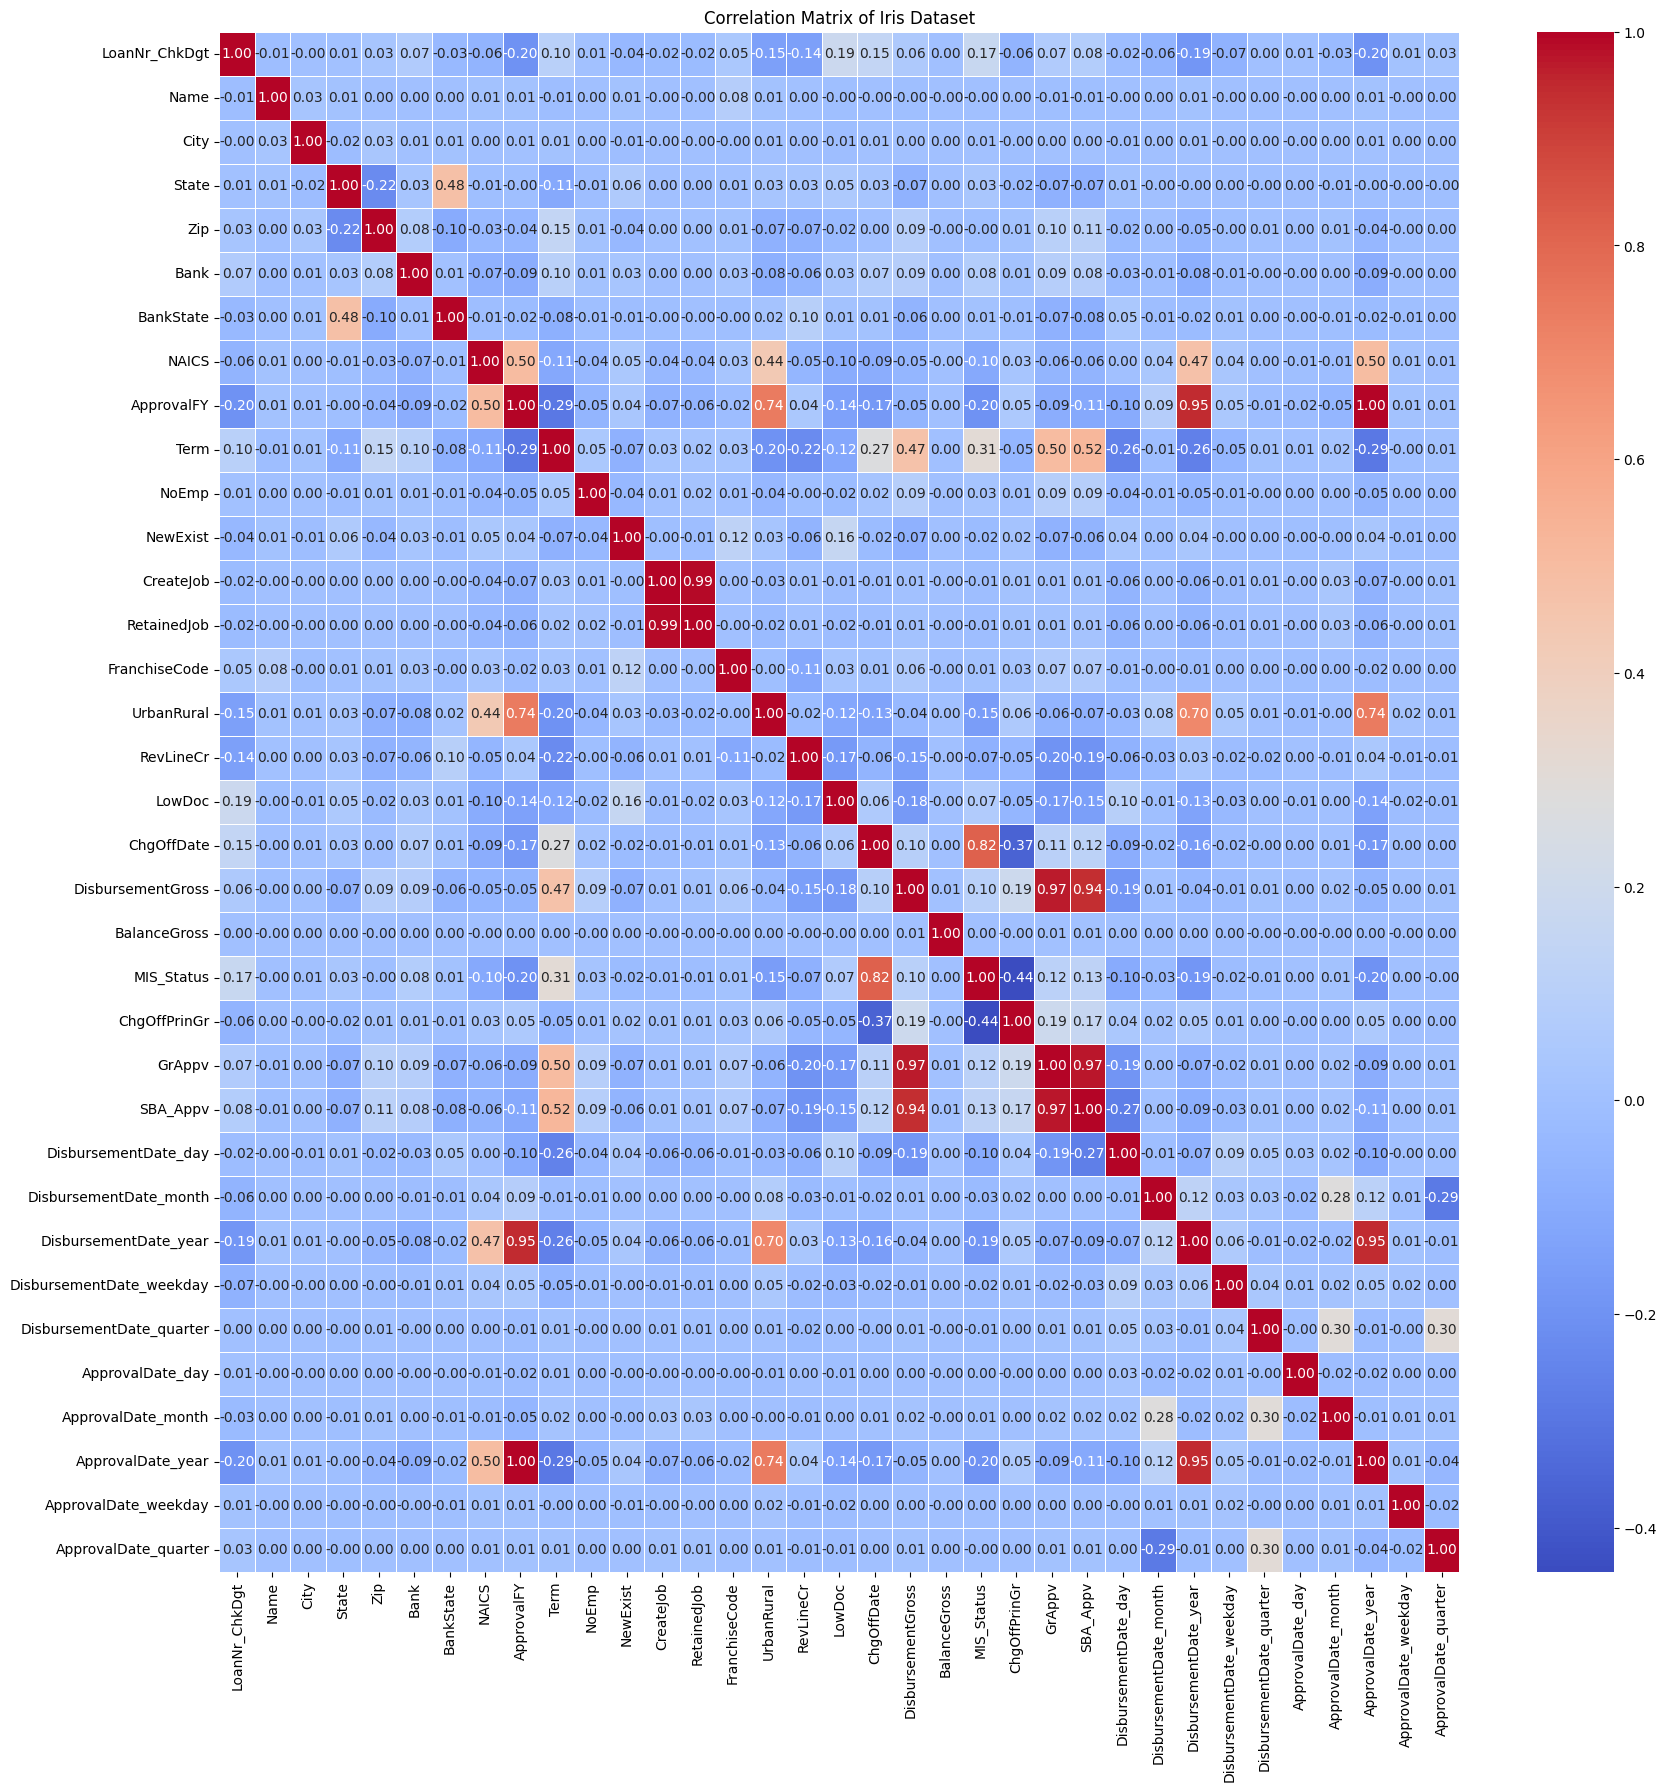

In [9]:
plt.figure(figsize=(20, 20)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Iris Dataset')
plt.show()

Neuronal Network to clasify potencial risks for the bank
status:Failed
As we have many categorical columns it is better for this modelo to keep our label enconding system and swicht to randomforesclassifier or xgboost, those are better managin label encoding

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam



# Separar features y target

X = df_tokenized.drop("MIS_Status_token", axis=1).values
y = df_tokenized['MIS_Status_token'].values  # binario: 0/1

In [10]:

# Split train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [ ]:

# Escalado de features (opcional)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)



In [44]:

# Definir el modelo

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    # Dense(32, activation='relu'),
    # Dense(128, activation='relu'),
    # Dense(128, activation='relu'),
    Dense(1, activation='relu')
  # salida binaria
])



In [45]:

#5. Compilar el modelo


# Definir optimizador con learning rate personalizado
opt = Adam(learning_rate=0.00005)  # por ejemplo 0.001, default de Adam

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])



In [46]:

# Entrenar

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)



Epoch 1/20
11240/11240 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.0444 - loss: 19.0357 - val_accuracy: 0.0022 - val_loss: 29.3403
Epoch 2/20
11240/11240 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.0441 - loss: 19.0665 - val_accuracy: 0.0022 - val_loss: 29.3403
Epoch 3/20
11240/11240 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.0449 - loss: 19.0593 - val_accuracy: 0.0022 - val_loss: 29.3403
Epoch 4/20
 8686/11240 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0443 - loss: 19.0313

KeyboardInterrupt: 

In [22]:

# Evaluar

loss, acc = model.evaluate(X_test, y_test)
print(f"\nAccuracy en test: {acc:.4f}")




5620/5620 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.0021 - loss: 29.3268

Accuracy en test: 0.0022


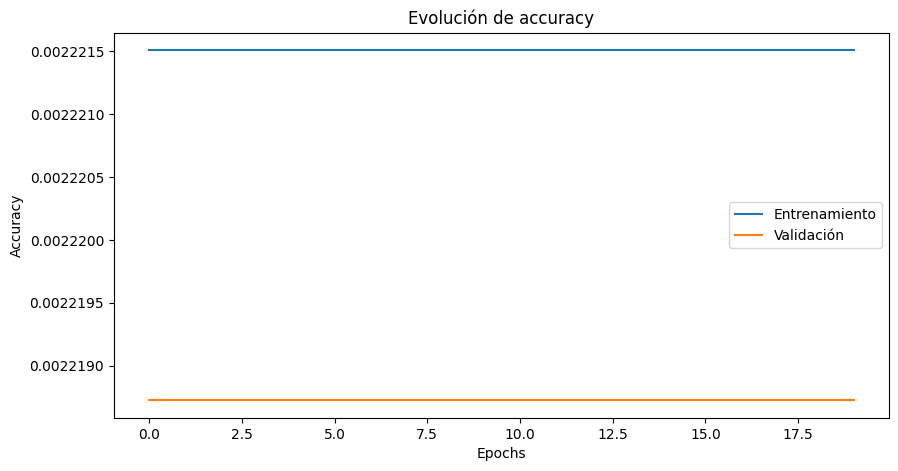

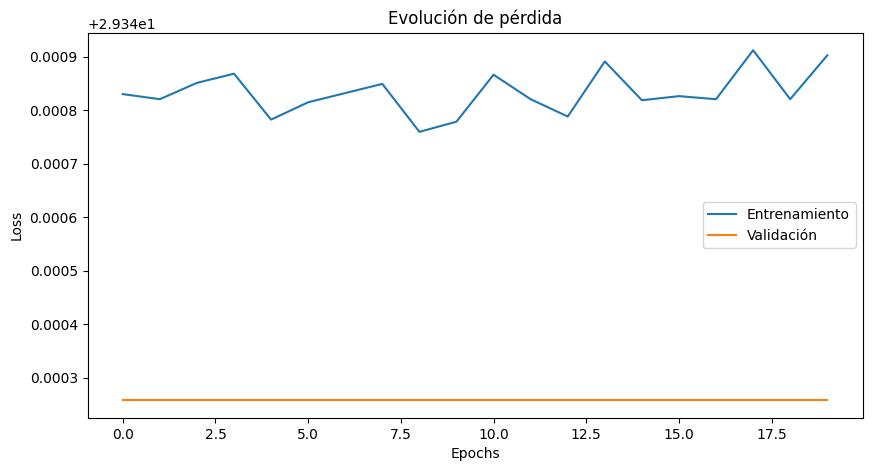

In [23]:

# Curvas de entrenamiento

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Evolución de accuracy')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Evolución de pérdida')
plt.show()

XGBoost Classifier

In [9]:
import pandas as pd
import random
import time
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

y = df_tokenized['MIS_Status']  # target
X = df_tokenized.drop('MIS_Status', axis=1)  # features

def test_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

results = []
start_total = time.time()

for i in range(1, 101):
    print(f"Ejecutando iteración {i}/100...")
    start_iter = time.time()

    # Hyperparámetros razonables
    e = random.randint(10, 300)   # n_estimators
    d = random.randint(3, 15)     # max_depth
    r = random.randint(1, 300)    # random_state

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=r, stratify=y
    )
    original_distribution = dict(Counter(y_train))

    # SMOTE para balancear clases
    smote = SMOTE(random_state=r)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Nuevo contador post-SMOTE
    res_distribution = dict(Counter(y_train_res))

    # XGBoost sin scale_pos_weight
    xgb_clf = XGBClassifier(
        n_estimators=e,
        max_depth=d,
        random_state=r,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    )
    xgb_metrics = test_model(xgb_clf, X_train_res, y_train_res, X_test, y_test)

    results.append({
        'n_estimators': e,
        'max_depth': d,
        'random_state': r,
        'original_distribution': original_distribution,
        'resampled_distribution': res_distribution,
        'xgb_accuracy': xgb_metrics['accuracy'],
        'xgb_precision': xgb_metrics['precision'],
        'xgb_recall': xgb_metrics['recall'],
        'xgb_f1_score': xgb_metrics['f1_score']
    })

    end_iter = time.time()
    print(f"Iteración {i} completada en {(end_iter - start_iter)/60:.2f} minutos.\n")

end_total = time.time()
print(f"Proceso completo en {(end_total - start_total)/60:.2f} minutos.")

results_df = pd.DataFrame(results)


Ejecutando iteración 1/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:46:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 1 completada en 0.81 minutos.

Ejecutando iteración 2/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:47:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 2 completada en 0.53 minutos.

Ejecutando iteración 3/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:47:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 3 completada en 1.11 minutos.

Ejecutando iteración 4/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 4 completada en 1.39 minutos.

Ejecutando iteración 5/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:50:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 5 completada en 0.66 minutos.

Ejecutando iteración 6/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:50:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 6 completada en 0.94 minutos.

Ejecutando iteración 7/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 7 completada en 1.25 minutos.

Ejecutando iteración 8/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 8 completada en 0.98 minutos.

Ejecutando iteración 9/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:54:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 9 completada en 1.09 minutos.

Ejecutando iteración 10/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:55:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 10 completada en 0.69 minutos.

Ejecutando iteración 11/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:55:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 11 completada en 0.70 minutos.

Ejecutando iteración 12/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:56:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 12 completada en 1.37 minutos.

Ejecutando iteración 13/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:57:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 13 completada en 1.13 minutos.

Ejecutando iteración 14/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:59:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 14 completada en 1.13 minutos.

Ejecutando iteración 15/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:00:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 15 completada en 0.90 minutos.

Ejecutando iteración 16/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:01:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 16 completada en 1.26 minutos.

Ejecutando iteración 17/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:02:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 17 completada en 0.43 minutos.

Ejecutando iteración 18/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:02:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 18 completada en 1.40 minutos.

Ejecutando iteración 19/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 19 completada en 0.99 minutos.

Ejecutando iteración 20/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:05:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 20 completada en 0.81 minutos.

Ejecutando iteración 21/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:05:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 21 completada en 1.12 minutos.

Ejecutando iteración 22/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:07:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 22 completada en 0.72 minutos.

Ejecutando iteración 23/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:07:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 23 completada en 1.48 minutos.

Ejecutando iteración 24/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:09:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 24 completada en 1.27 minutos.

Ejecutando iteración 25/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:10:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 25 completada en 0.79 minutos.

Ejecutando iteración 26/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 26 completada en 0.73 minutos.

Ejecutando iteración 27/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 27 completada en 0.61 minutos.

Ejecutando iteración 28/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 28 completada en 0.64 minutos.

Ejecutando iteración 29/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:13:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 29 completada en 1.29 minutos.

Ejecutando iteración 30/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 30 completada en 0.50 minutos.

Ejecutando iteración 31/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:15:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 31 completada en 1.10 minutos.

Ejecutando iteración 32/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:16:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 32 completada en 0.90 minutos.

Ejecutando iteración 33/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:17:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 33 completada en 0.87 minutos.

Ejecutando iteración 34/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:17:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 34 completada en 0.78 minutos.

Ejecutando iteración 35/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:18:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 35 completada en 0.43 minutos.

Ejecutando iteración 36/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:19:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 36 completada en 0.60 minutos.

Ejecutando iteración 37/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:19:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 37 completada en 1.34 minutos.

Ejecutando iteración 38/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:21:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 38 completada en 1.59 minutos.

Ejecutando iteración 39/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 39 completada en 1.72 minutos.

Ejecutando iteración 40/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:24:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 40 completada en 0.94 minutos.

Ejecutando iteración 41/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:25:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 41 completada en 1.54 minutos.

Ejecutando iteración 42/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 42 completada en 1.20 minutos.

Ejecutando iteración 43/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:28:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 43 completada en 0.90 minutos.

Ejecutando iteración 44/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:29:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 44 completada en 1.19 minutos.

Ejecutando iteración 45/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:30:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 45 completada en 0.80 minutos.

Ejecutando iteración 46/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:31:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 46 completada en 1.79 minutos.

Ejecutando iteración 47/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:32:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 47 completada en 1.35 minutos.

Ejecutando iteración 48/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 48 completada en 0.73 minutos.

Ejecutando iteración 49/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 49 completada en 1.31 minutos.

Ejecutando iteración 50/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:36:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 50 completada en 0.97 minutos.

Ejecutando iteración 51/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:37:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 51 completada en 1.17 minutos.

Ejecutando iteración 52/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:38:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 52 completada en 1.31 minutos.

Ejecutando iteración 53/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 53 completada en 1.36 minutos.

Ejecutando iteración 54/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 54 completada en 1.07 minutos.

Ejecutando iteración 55/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:42:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 55 completada en 0.87 minutos.

Ejecutando iteración 56/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:42:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 56 completada en 1.56 minutos.

Ejecutando iteración 57/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 57 completada en 0.93 minutos.

Ejecutando iteración 58/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:45:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 58 completada en 0.63 minutos.

Ejecutando iteración 59/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:45:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 59 completada en 0.72 minutos.

Ejecutando iteración 60/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 60 completada en 1.38 minutos.

Ejecutando iteración 61/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 61 completada en 0.85 minutos.

Ejecutando iteración 62/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 62 completada en 0.71 minutos.

Ejecutando iteración 63/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:49:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 63 completada en 0.94 minutos.

Ejecutando iteración 64/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:50:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 64 completada en 1.15 minutos.

Ejecutando iteración 65/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:51:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 65 completada en 0.50 minutos.

Ejecutando iteración 66/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:52:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 66 completada en 1.32 minutos.

Ejecutando iteración 67/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:53:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 67 completada en 1.44 minutos.

Ejecutando iteración 68/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 68 completada en 0.92 minutos.

Ejecutando iteración 69/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 69 completada en 0.72 minutos.

Ejecutando iteración 70/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:56:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 70 completada en 0.68 minutos.

Ejecutando iteración 71/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:57:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 71 completada en 0.63 minutos.

Ejecutando iteración 72/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:57:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 72 completada en 0.80 minutos.

Ejecutando iteración 73/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:59:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 73 completada en 0.82 minutos.

Ejecutando iteración 74/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:59:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 74 completada en 0.57 minutos.

Ejecutando iteración 75/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:00:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 75 completada en 0.95 minutos.

Ejecutando iteración 76/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:00:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 76 completada en 0.64 minutos.

Ejecutando iteración 77/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:01:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 77 completada en 1.30 minutos.

Ejecutando iteración 78/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:02:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 78 completada en 0.78 minutos.

Ejecutando iteración 79/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:03:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 79 completada en 0.80 minutos.

Ejecutando iteración 80/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:04:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 80 completada en 0.39 minutos.

Ejecutando iteración 81/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:05:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 81 completada en 0.95 minutos.

Ejecutando iteración 82/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:05:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 82 completada en 0.35 minutos.

Ejecutando iteración 83/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:06:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 83 completada en 0.42 minutos.

Ejecutando iteración 84/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:07:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 84 completada en 1.52 minutos.

Ejecutando iteración 85/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 85 completada en 0.95 minutos.

Ejecutando iteración 86/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:09:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 86 completada en 1.21 minutos.

Ejecutando iteración 87/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:10:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 87 completada en 0.97 minutos.

Ejecutando iteración 88/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:11:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 88 completada en 1.51 minutos.

Ejecutando iteración 89/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:12:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 89 completada en 0.62 minutos.

Ejecutando iteración 90/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 90 completada en 1.75 minutos.

Ejecutando iteración 91/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:15:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 91 completada en 1.12 minutos.

Ejecutando iteración 92/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:16:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 92 completada en 0.49 minutos.

Ejecutando iteración 93/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 93 completada en 0.90 minutos.

Ejecutando iteración 94/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:17:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 94 completada en 1.25 minutos.

Ejecutando iteración 95/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:19:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 95 completada en 0.87 minutos.

Ejecutando iteración 96/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:19:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 96 completada en 1.76 minutos.

Ejecutando iteración 97/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:21:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 97 completada en 0.72 minutos.

Ejecutando iteración 98/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 98 completada en 1.45 minutos.

Ejecutando iteración 99/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 99 completada en 0.95 minutos.

Ejecutando iteración 100/100...


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Iteración 100 completada en 1.16 minutos.

Proceso completo en 99.61 minutos.


In [10]:
results_df.sort_values(by='xgb_accuracy',ascending=False).head(3)

,n_estimators,max_depth,random_state,original_distribution,resampled_distribution,xgb_accuracy,xgb_precision,xgb_recall,xgb_f1_score
82,75,6,125,"{0: 110290, 1: 517726, 2: 1398}","{0: 517726, 1: 517726, 2: 517726}",0.994647,0.994792,0.994647,0.994677
75,167,7,167,"{1: 517726, 0: 110290, 2: 1398}","{1: 517726, 0: 517726, 2: 517726}",0.994617,0.994751,0.994617,0.994646
66,272,14,186,"{1: 517726, 0: 110290, 2: 1398}","{1: 517726, 0: 517726, 2: 517726}",0.994614,0.994759,0.994614,0.994643


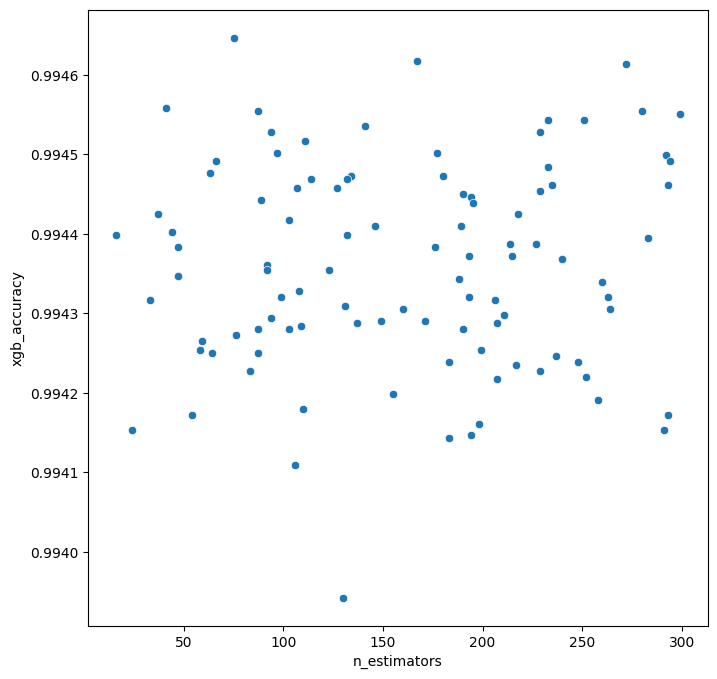

In [11]:
import matplotlib.ticker as ticker
plt.figure(figsize=(8, 8))

sns.scatterplot(x=results_df['n_estimators'], y=results_df['xgb_accuracy'])

plt.show()

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Target y features
y = df_tokenized['MIS_Status']
X = df_tokenized.drop('MIS_Status', axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125, stratify=y
)

print("Distribución original:", dict(Counter(y_train)))

# SMOTE
smote = SMOTE(random_state=31)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Distribución después de SMOTE:", dict(Counter(y_train_res)))

# Entrenar XGBoost sin scale_pos_weight
model = XGBClassifier(
    n_estimators=75,
    max_depth=6,
    random_state=125,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)

# Predicciones
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Distribución original: {0: 110290, 1: 517726, 2: 1398}
Distribución después de SMOTE: {0: 517726, 1: 517726, 2: 517726}


c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:30:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.9946
Precision: 0.9948
Recall: 0.9946
F1-score: 0.9946


prediction

In [13]:
df_test=pd.read_csv(r'C:\Users\alejo\Desktop\FAMILIA\Alejo\TECH\developments\PERSONAL DEVELOPMENTS\Machine-learning-projects\linear-regression\aliquota_test.csv')
df_test.head(2)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,7435084009,TMP PHARMACY LLC,TOMBALL,TX,77375,WOODFOREST NATIONAL BANK,TX,446110,13-May-04,2004,84,2,1.0,0,2,1,1,Y,N,NaN,30-Jun-04,"$100,000.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00"
1,4027545009,ATLAS CHIROPRACTIC OF LIGONIER,LIGONIER,PA,15658,CITIZENS BANK OF PENNSYLVANIA,PA,621310,14-Apr-10,2010,60,1,1.0,0,1,0,1,N,N,NaN,14-Apr-10,"$88,200.00",$0.00,P I F,$0.00,"$88,200.00","$44,100.00"


In [14]:
df_test=preprocess_cash_and_dates(df_test)
df_test=encode_for_tree_models(df_test)
df_test


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,DisbursementDate_day,DisbursementDate_month,DisbursementDate_year,DisbursementDate_weekday,DisbursementDate_quarter,ApprovalDate_day,ApprovalDate_month,ApprovalDate_year,ApprovalDate_weekday,ApprovalDate_quarter
0,7.435084e+09,47,42,22,77375.0,40,18,446110.0,2004.0,84.0,2.0,1.0,0.0,2.0,1.0,1.0,2,0,8,100000.0,0.0,1,0.0,50000.0,25000.0,10,9,13,2,2,3,7,10,3,1
1,4.027545e+09,1,18,18,15658.0,10,16,621310.0,2010.0,60.0,1.0,1.0,0.0,1.0,0.0,1.0,1,0,8,88200.0,0.0,1,0.0,88200.0,44100.0,4,7,19,2,2,4,6,16,2,1
2,2.416765e+09,16,21,24,20110.0,4,1,448120.0,2007.0,39.0,1.0,2.0,0.0,1.0,0.0,1.0,1,0,3,25000.0,0.0,0,15922.0,25000.0,21250.0,10,7,16,0,2,15,6,13,2,1
3,7.071644e+09,37,35,20,57103.0,18,17,484121.0,2004.0,48.0,3.0,2.0,0.0,0.0,1.0,1.0,0,1,8,45400.0,0.0,1,0.0,45400.0,38590.0,11,1,13,5,1,17,3,9,0,3
4,4.836763e+09,6,39,2,95206.0,22,3,0.0,1992.0,204.0,15.0,1.0,0.0,0.0,1.0,0.0,1,0,8,1000000.0,0.0,1,0.0,1000000.0,750000.0,11,10,3,4,3,22,7,2,3,1
5,7.706494e+09,18,40,14,3585.0,25,21,721191.0,2004.0,201.0,1.0,2.0,0.0,0.0,1.0,2.0,1,0,0,335000.0,0.0,0,58607.0,335000.0,251250.0,10,12,13,3,3,8,9,10,2,2
6,9.028574e+09,13,44,23,84405.0,34,19,523920.0,2005.0,240.0,2.0,1.0,3.0,0.0,1.0,1.0,0,0,8,106000.0,0.0,1,0.0,106000.0,106000.0,2,1,15,2,1,20,9,11,4,2
7,4.993674e+09,45,23,11,55427.0,35,10,812990.0,2002.0,84.0,4.0,1.0,0.0,0.0,1.0,1.0,0,1,8,150000.0,0.0,1,0.0,150000.0,127500.0,11,2,10,2,4,9,1,8,4,3
8,3.389964e+09,34,36,2,96150.0,12,18,0.0,2000.0,288.0,1.0,2.0,4.0,1.0,1.0,1.0,0,0,8,642000.0,0.0,1,0.0,687000.0,515250.0,11,1,9,0,1,7,2,7,2,3
9,3.589085e+09,12,31,11,55902.0,21,10,485320.0,2009.0,63.0,16.0,1.0,0.0,16.0,0.0,1.0,1,0,8,680000.0,0.0,1,0.0,680000.0,612000.0,10,12,18,2,3,11,9,15,4,2


In [15]:
df_predicction=df_test.drop("MIS_Status", axis=1).values
new_pred = model.predict(df_predicction)

predictions = pd.DataFrame(new_pred, columns=['MIS_Status'])

predictions.to_csv("MIS_Status-predictions.csv", index=False)

checking predicctions

Accuracy: 0.6000
Precision: 0.9077
Recall: 0.6000
F1-score: 0.6662
[[ 6  0]
 [20 24]]
[[1.         0.        ]
 [0.45454545 0.54545455]]


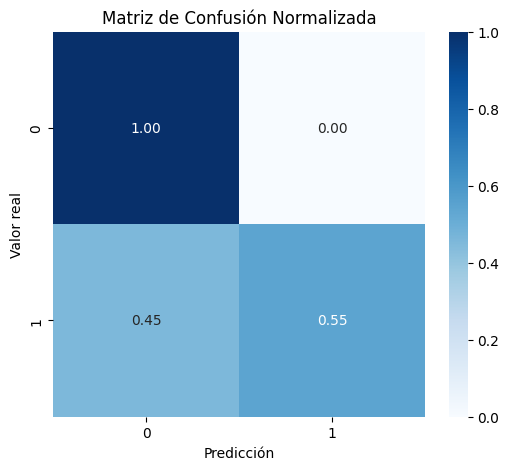

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que ya tenés:
# y_test_new -> valores reales
# y_pred_new -> predicciones del modelo (model.predict)

# Métricas principales
accuracy = accuracy_score(df_test['MIS_Status'],new_pred)
precision = precision_score(df_test['MIS_Status'], new_pred, average='weighted', zero_division=0)
recall = recall_score(df_test['MIS_Status'], new_pred, average='weighted', zero_division=0)
f1 = f1_score(df_test['MIS_Status'], new_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


# Matriz de confusión
cm = confusion_matrix(df_test['MIS_Status'],new_pred)
print(cm)
# Plot matriz de confusión normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=np.unique(df_test['MIS_Status']),
            yticklabels=np.unique(df_test['MIS_Status']))
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión Normalizada')
plt.show()


In [17]:
from sklearn.metrics import classification_report

print(classification_report(df_test['MIS_Status'], new_pred))


              precision    recall  f1-score   support

           0       0.23      1.00      0.38         6
           1       1.00      0.55      0.71        44

    accuracy                           0.60        50
   macro avg       0.62      0.77      0.54        50
weighted avg       0.91      0.60      0.67        50



RandomForestClasifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color="skyblue")
plt.title("Random Forest Performance")
plt.ylim(0,1)
plt.show()